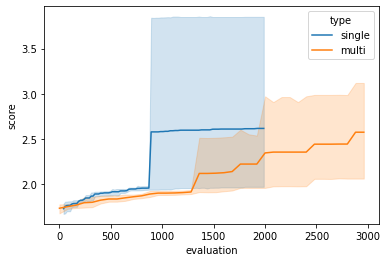

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns

root_dir = os.path.dirname(Path().resolve())
root_dir=os.path.join(root_dir, 'examples')
seed=10
expr_name='Jumper-v0_PlatformJumper-v0'
expr_name_single='PlatformJumper-v0_GA'


generation=31


def max_fit_list(save_dir,generation,is_multi=False):
    fitness_gen=[]
    evaluation_list=[]
    for i in range(generation+1):
        log_dir = os.path.join(save_dir,'generation_'+str(i),'output.txt')
        with open(log_dir) as f:
            fitnesses=[]
            for line in f:
                try:
                    if is_multi:
                        fitnesses.append(float(line.split()[2]))
                    else:
                        fitnesses.append(float(line.split()[1]))
                except:
                    evaluation_list.append(int(line.split()[2]))
            if is_multi:
                evaluation_list.append(fitnesses[len(fitnesses)-1])
                del fitnesses[len(fitnesses)-1]
            fitness_gen.append(max(fitnesses))
    return fitness_gen,evaluation_list

def average_graph(expr_name,seed_list,generation,is_multi):
    mat=np.empty([0,generation+1])
    for seed in seed_list:
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        np_arr=np.array(fitness_list)[np.newaxis,:]
        mat=np.concatenate([mat,np_arr])
    data=np.average(mat,axis=0)
    return data,evaluation_list

def data_for_confidence(expr_name,seed_list,generation,is_multi):
    df=pd.DataFrame(columns=['evaluation','score'])
    for seed in seed_list:
        sub_df = pd.DataFrame(columns=['evaluation','score'])
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        sub_df['evaluation'] = np.array([80*i for i in range(generation+1)]) if is_multi else evaluation_list
        sub_df['score'] = fitness_list
        df = df.append(sub_df)
    elem='multi' if is_multi else 'single'
    df['type']=np.array([elem for i in range(len(df))])
    return df

# def data_for_confidence_multi(...):
# data_for_confidence()
# list
# data['hue'] = list

def plot_confidence(df):
    sns.lineplot(x="evaluation", y="score", data=df,hue='type')
    plt.xlabel('evaluation')
    plt.savefig('evaluation_score.pdf')

def plot_graph(data,eval_list,label,is_eval_base=True):
    fig = plt.figure(figsize=(12, 8)) #...1
    
    # Figure内にAxesを追加()
    ax = fig.add_subplot(111) #...2
    if is_eval_base==False:
        eval_list[1]=np.array(eval_list[1])/2
    ax.plot(eval_list[1], data[1], label=label[1]) #...3
    ax.plot(eval_list[0], data[0], label=label[0]) #...3
    plt.xlabel('evaluations' if is_eval_base else 'evaluated design')
    plt.ylabel('score of platformjumper')
    plt.ylim([1.7,2.8])

    # 凡例の表示
    plt.legend()

    # プロット表示(設定の反映)
    plt.show()
    
data_single,eval_list_single=average_graph(expr_name_single,[0,10,20,30],86,False)#ここの世代数変えて出力
data_multi,eval_list_multi=average_graph(expr_name,[0,10,20,30,40],37,True)
df=data_for_confidence(expr_name_single,[0,10,20,30],86,False)
df_multi=data_for_confidence(expr_name,[0,10,20,30,40],37,True)
plot_confidence(df.append(df_multi))
#plot_confidence(df.append(df_multi))
#plot_graph([data_single,data_multi],[eval_list_single,eval_list_multi],['GA:4 seed average','multi:5 seed average'])